1. 모듈 불러오기
2. dtype, device, batch_size 설정
3. 데이터 로드(필요 시 전처리)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 데이터 로드
batch_size = 128
data_path = '/tmp/data/mnist'
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True) #배치 단위 이터러블 데이터 생성
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

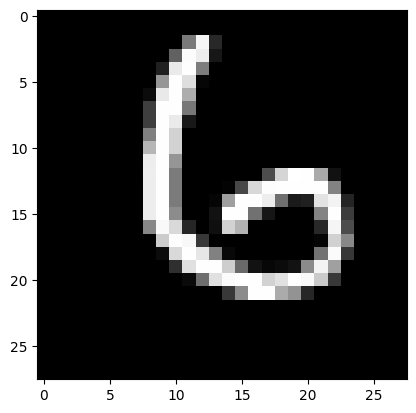

torch.Size([128, 1, 28, 28])


In [27]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)
plt.imshow(data[0].cpu().squeeze(), cmap='gray')
plt.show()
print(data.shape)

4. 모델, 손실, 옵티마이저 정의

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # (batch, 32, 14, 14)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # (batch, 64, 7, 7)
        x = x.view(x.size(0), -1)                    # (batch, 64*7*7)
        x = self.fc1(x)                              # (batch, 10)
        return x

#net, loss, optimizer 정의
net = Net().to(device)
loss_fn=nn.CrossEntropyLoss() #모델 출력이 클래스 별 점수(확률 값)으로 나올 때
optimizer=torch.optim.Adam(net.parameters(),lr=0.001)

In [42]:
#정확도 plot 위한 함수
def batch_accuracy(train_loader, net):
  with torch.no_grad():
    total = 0
    correct = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      outputs = net(data) #[batch, 10]
      _, predicted = torch.max(outputs.data, 1) #가장 큰 확률 값 == 예측 값
      #맞춘 개수를 배치 수로 나눠 정확도 측정
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

  return correct / total

5. 학습

In [44]:
from tqdm import tqdm

num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

for epoch in range(num_epochs):
    net.train()  # 학습 모드 전환
    running_loss = 0.0

    # tqdm으로 진행도 표시
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for data, targets in progress_bar:
        data, targets = data.to(device), targets.to(device)

        # 순전파
        outputs = net(data)
        loss_val = loss_fn(outputs, targets)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # 손실 누적
        running_loss += loss_val.item()

        # 진행도바에 현재 배치 손실 표시
        progress_bar.set_postfix(loss=f"{loss_val.item():.4f}")

    # 평균 손실 계산
    avg_loss = running_loss / len(train_loader)
    loss_hist.append(avg_loss)

    # 에포크 종료 후 테스트 정확도 평가
    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(test_loader, net)
        test_acc_hist.append(test_acc)
        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")


[Epoch 1/1] Loss: 0.0344, Test Accuracy: 98.80%


6. 테스트

===== 단일 테스트 결과 =====


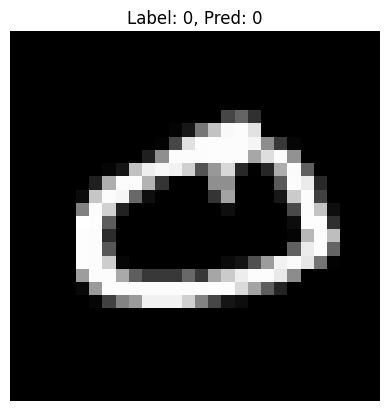

In [47]:
import random
import torch

# test_loader에서 한 배치 불러오기
data_iter = iter(test_loader)
images, labels = next(data_iter)

# 무작위로 하나의 인덱스 선택
idx = random.randint(0, len(images) - 1)
image = images[idx].unsqueeze(0).to(device)  # 모델에 입력하기 위해 [1, 1, 28, 28] 형태로 변환
label = labels[idx].item()

# 모델 예측
net.eval()
with torch.no_grad():
    output = net(image)
    _, predicted = torch.max(output.data, 1)
    predicted_label = predicted.item()

print("===== 단일 테스트 결과 =====")
plt.imshow(images[idx].squeeze().cpu(), cmap='gray')
plt.title(f"Label: {label}, Pred: {predicted_label}")
plt.axis('off')
plt.show()
